In [1]:
# VGG19
# img clf
# Kaggle에서 필요한 데이터셋을 다운받고 압축 해제를 진행합니다.

from google.colab import drive
drive.mount('/content/drive')

!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Mounted at /content/drive
 98% 726M/745M [00:03<00:00, 201MB/s]
100% 745M/745M [00:04<00:00, 188MB/s]


In [2]:
!unzip covid19-radiography-database.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating: COVID-19_Radio

In [3]:
img_n_path = '/content/COVID-19_Radiography_Dataset/Normal' # 0
#img_o_path = '/content/COVID-19_Radiography_Dataset/Lung_Opacity' # 1
img_v_path = '/content/COVID-19_Radiography_Dataset/Viral Pneumonia' # 1
img_c_path = '/content/COVID-19_Radiography_Dataset/COVID' # 2

In [4]:
import os

filenames = os.listdir(img_n_path) + os.listdir(img_v_path) + os.listdir(img_c_path) #+ os.listdir(img_o_path)
len(filenames)

15153

In [5]:
# labeling

labels = []

for filename in filenames:
  label = filename.split('-')[0]
  if label == 'Normal':
    labels.append(str(0))
  # elif label == 'Lung_Opacity':
  #   labels.append(str(1))
  elif label == 'Viral Pneumonia':
    labels.append(str(1))
  else:
    labels.append(str(2))

len(labels)

15153

In [6]:
# Converting to dataframe

import pandas as pd

for i in range(len(filenames)):
  if 'Normal' in filenames[i]:
    filenames[i] = os.path.join(img_n_path, filenames[i])
  # elif 'Lung_Opacity' in filenames[i]:
  #   filenames[i] = os.path.join(img_o_path, filenames[i])
  elif 'Viral Pneumonia' in filenames[i]:
    filenames[i] = os.path.join(img_v_path, filenames[i])
  else:
    filenames[i] = os.path.join(img_c_path, filenames[i])

df = pd.DataFrame({'filename' : filenames, 
                   'label' : labels})

df

,filename,label
0,/content/COVID-19_Radiography_Dataset/Normal/N...,0
1,/content/COVID-19_Radiography_Dataset/Normal/N...,0
2,/content/COVID-19_Radiography_Dataset/Normal/N...,0
3,/content/COVID-19_Radiography_Dataset/Normal/N...,0
4,/content/COVID-19_Radiography_Dataset/Normal/N...,0
...,...,...
15148,/content/COVID-19_Radiography_Dataset/COVID/CO...,2
15149,/content/COVID-19_Radiography_Dataset/COVID/CO...,2
15150,/content/COVID-19_Radiography_Dataset/COVID/CO...,2
15151,/content/COVID-19_Radiography_Dataset/COVID/CO...,2


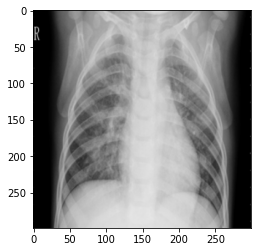

In [7]:
# 예시

import random
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import load_img

sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(df, test_size = .2, shuffle = True, random_state=42, stratify=df['label'])
X_train, X_valid = train_test_split(X_train, test_size = .2, shuffle = True, random_state=42, stratify=X_train['label'])

X_train = X_train.reset_index(drop=True)
X_valid = X_valid.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

X_train.shape, X_valid.shape, X_test.shape

((9697, 2), (2425, 2), (3031, 2))

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rotation_range=15, 
                                    rescale=1./255, 
                                    shear_range=0.1, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

train_generator = train_data_gen.flow_from_dataframe(X_train, 
                                                     x_col='filename', 
                                                     y_col='label', 
                                                     target_size=(224,224), 
                                                     class_mode='categorical', 
                                                     batch_size=15)

Found 9697 validated image filenames belonging to 3 classes.


In [10]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(X_valid, 
                                                     x_col='filename',
                                                     y_col='label',
                                                     target_size=(224,224),
                                                     class_mode='categorical',
                                                     batch_size=15)

Found 2425 validated image filenames belonging to 3 classes.


In [11]:
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout
from keras.models import Model

baseModel = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = MaxPooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=0.0002)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose = 1, patience = 5)
checkpoint = ModelCheckpoint('best_model2.h5', monitor='val_loss', mode='min', save_best_only=True)

In [16]:
epochs = 200
history = model.fit(train_generator, validation_data=valid_generator, verbose=1, epochs=epochs, callbacks=[early_stopping, checkpoint])

Epoch 1/200
647/647 [==============================] - 128s 198ms/step - loss: 0.5346 - accuracy: 0.7668 - val_loss: 0.3823 - val_accuracy: 0.8487
Epoch 2/200
647/647 [==============================] - 125s 194ms/step - loss: 0.4253 - accuracy: 0.8226 - val_loss: 0.3705 - val_accuracy: 0.8437
Epoch 3/200
647/647 [==============================] - 125s 193ms/step - loss: 0.3865 - accuracy: 0.8381 - val_loss: 0.3191 - val_accuracy: 0.8656
Epoch 4/200
647/647 [==============================] - 125s 193ms/step - loss: 0.3570 - accuracy: 0.8535 - val_loss: 0.2740 - val_accuracy: 0.8936
Epoch 5/200
647/647 [==============================] - 125s 193ms/step - loss: 0.3448 - accuracy: 0.8576 - val_loss: 0.2739 - val_accuracy: 0.8895
Epoch 6/200
647/647 [==============================] - 126s 194ms/step - loss: 0.3279 - accuracy: 0.8664 - val_loss: 0.2358 - val_accuracy: 0.9068
Epoch 7/200
647/647 [==============================] - 125s 193ms/step - loss: 0.3222 - accuracy: 0.8705 - val_loss: 0

True value is : Normal
Prediction is : Normal


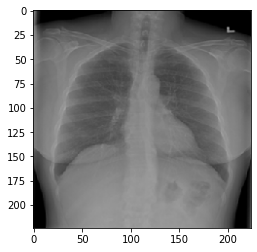

In [25]:
from keras.preprocessing.image import img_to_array
import numpy as np

sample = random.choice(X_test.index)
img_dir = X_test.loc[sample][0]
img_label = X_test.loc[sample][1]

true = ''
if img_label == '0':
  true = 'Normal'
# elif img_label == '1':
#   true = 'Lung_Opacity'
elif img_label == '1':
  true = 'Viral Pneumonia'
else:
  true = 'COVID'

image = load_img(img_dir, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis = -1)

pred = ''
if result == 0:
  pred = 'Normal'
# elif result == 1:
#   pred = 'Lung_Opacity'
elif result == 1:
  pred = 'Viral Pneumonia'
else:
  pred = 'COVID'

print(f'True value is : {true}')
print(f'Prediction is : {pred}')

plt.imshow(image);